In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(34, 34), dpi=80, facecolor='w', edgecolor='k')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

<Figure size 2720x2720 with 0 Axes>

In [56]:
icu_bed = pd.read_csv('data-FPBfZ.csv')

## **ICU Bed Dataset** ##
Data retrieved from this link: https://khn.org/news/as-coronavirus-spreads-widely-millions-of-older-americans-live-in-counties-with-no-icu-beds/?utm_campaign=The%20Batch&utm_source=hs_email&utm_medium=email&utm_content=86805016&_hsenc=p2ANqtz-8mqCGwRJH77ohCQz3MXG72X3ESuvEk4ltbUFmBfz08qWT_lcHaeAOwZ93wez969IUi3ZEdNa1qxmuTZzsjYbNJ6wH4tw&_hsmi=86805016#lookup 

In [5]:
icu_bed.head()

,State,County,ICU Beds,Total Population,Population Aged 60+,Percent of Population Aged 60+,Residents Aged 60+ Per Each ICU Bed
0,Alabama,Autauga,6,55036,10523,19.1,1754.0
1,Alabama,Baldwin,51,203360,53519,26.3,1049.0
2,Alabama,Barbour,5,26201,6150,23.5,1230.0
3,Alabama,Bibb,0,22580,4773,21.1,NaN
4,Alabama,Blount,6,57667,13600,23.6,2267.0


In [57]:
us_county = pd.read_csv('us-counties.csv')

## US County COVID-19 Dataset ##

Data retrieved from this link: https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset

In [7]:
us_county.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [58]:
us_county['date'] = pd.to_datetime(us_county.date)

In [59]:
icu_bed_county_cases = pd.merge(us_county, icu_bed,  how='left', left_on=['county','state'], right_on = ['County','State'])

## Combine the two datasets ##

### I combine the two datasets so that I am able to compare case rate and the avaialble ICU Beds ###

In [9]:
icu_bed_county_cases.head()

,date,county,state,fips,cases,deaths,State,County,ICU Beds,Total Population,Population Aged 60+,Percent of Population Aged 60+,Residents Aged 60+ Per Each ICU Bed
0,2020-01-21,Snohomish,Washington,53061.0,1,0,Washington,Snohomish,72.0,771904.0,143234.0,18.6,1989.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,Washington,Snohomish,72.0,771904.0,143234.0,18.6,1989.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,Washington,Snohomish,72.0,771904.0,143234.0,18.6,1989.0
3,2020-01-24,Cook,Illinois,17031.0,1,0,Illinois,Cook,1606.0,5238541.0,1005046.0,19.2,626.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,Washington,Snohomish,72.0,771904.0,143234.0,18.6,1989.0


## Create an ICU Hospitalization Column ##

I don't know the number of hospitalization cases that require ICU.  But I can calculate a rate based on the rate of Clark County (my home County which is Las Vegas).  This is the latest COVID-19 case report from Southern Nevada Health District (SNHD) from as of 4/23/2020: http://media.southernnevadahealthdistrict.org/download/COVID-19/updates/20200423-Daily-Aggregate-COVID19.pdf.  

- In Las Vegas we have had a total of 3443 cases of COVID-19
- Of those 3443 cases, 287 cases resulted in ICU
- 287/3443 = .0833 = 8.33%, 8.33% of COVID-19 cases in Clark County result in ICU treatment
- I create a new column that takes the number of cases for the day and multiplies by 8.33% to get the ICU cases


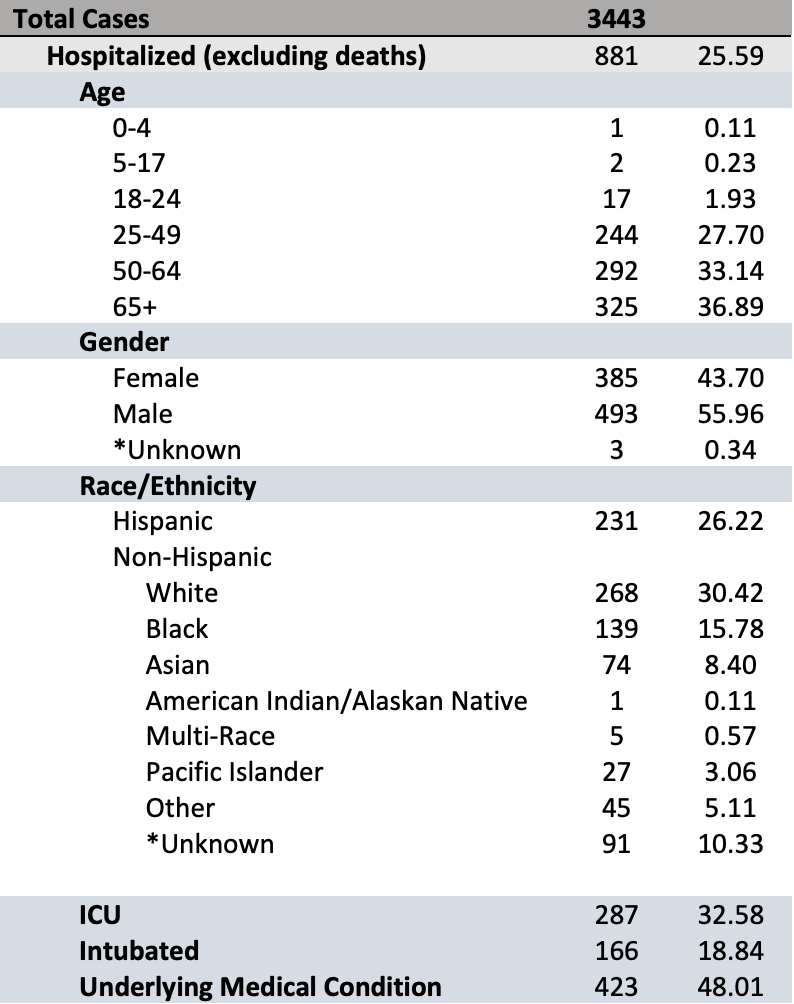

In [10]:
from IPython.display import Image
Image('Clark County Hospitalizations.png')

In [35]:
def plot_icu_bed_cases_time_series(County, State, date):
    
    """
    Function that creates a dataframe for a specific County and then plots the hypothetical ICU cases
    and then the plots the available ICU beds
    
    :param County: County in the form like 'Clark', this is the name of the county in the state
    :param State: State in the form like 'Nevada', this is the name state that contains that County
    :return: time series plot with available ICU beds and the number of ICU cases
    """
    
    county_icu_bed_and_cases = icu_bed_county_cases[(icu_bed_county_cases.county == County) & (icu_bed_county_cases.state == State)]
    county_icu_bed_and_cases['ICU Cases'] = county_icu_bed_and_cases.apply(lambda row: row.cases * .0833, axis = 1)
    
    icu_series = county_icu_bed_and_cases['ICU Cases']
    county_icu_bed_and_cases['ICU Diff'] = icu_series.diff()
    
    current_cases = county_icu_bed_and_cases[(county_icu_bed_and_cases.date) == date ].iloc[0,13]
    case_rate = county_icu_bed_and_cases[(county_icu_bed_and_cases.date) == date ].iloc[0,14]
    icu_bed_limit = county_icu_bed_and_cases[(county_icu_bed_and_cases.date) == date].iloc[0,8]
    remaining_beds = icu_bed_limit - current_cases
    days_until_max = remaining_beds / case_rate

    
    county_time_series = county_icu_bed_and_cases[['date', 'ICU Cases', 'ICU Beds']]
    county_time_series.index = county_time_series.date
    county_time_series = county_time_series.drop(['date'], axis = 1)
    
    county_time_series.plot()
    plt.title('Number of ICU cases vs Number Available ICU beds, ' + '{} County, {}'.format(County, State))
    plt.ylabel('ICU Beds')
    plt.legend(loc = 'center left')
    
    if remaining_beds > 0:
        print('As of {} at the current rate, there are {} days until reaching max ICU capacity'.format(date, days_until_max))
    else:
        print('Max ICU Bed capacity has been reached')

In [29]:
def icu_bed_limit(County, State):
    
    """
    Function returns the number of ICU beds in a given county
    
    :param County: County in the form like 'Clark', this is the name of the county in the state
    :param State: State in the form like 'Nevada', this is the name state that contains that County
    :return: number of ICU beds available in that county
    """
    
    county_icu_bed_and_cases = icu_bed_county_cases[(icu_bed_county_cases.county == County) & (icu_bed_county_cases.state == State)]
    return 'The number of ICU beds for {} County, {} is {} beds'.format(County, State, county_icu_bed_and_cases.iloc[0,8])


In [38]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [13]:
icu_bed_limit('Clark', 'Nevada')

'The number of ICU beds for Clark County, Nevada is 535.0 beds'

/Users/lorenzmadarang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


As of 2020-04-23 at the current rate, there are 124.52267060670437 days until reaching max ICU capacity


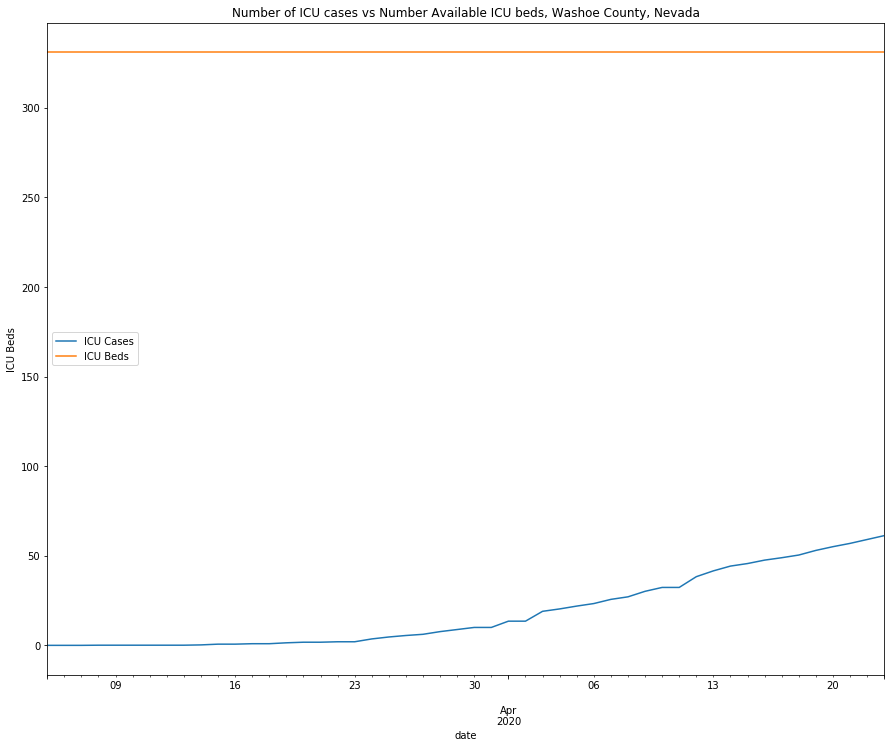

In [75]:
plot_icu_bed_cases_time_series('Washoe', 'Nevada', '2020-04-23')

In [63]:
icu_bed_limit('Suffolk', 'New York')

'The number of ICU beds for Suffolk County, New York is 281.0 beds'